# EDA

## Data Manipulation

In [41]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import plotly.express as px

In [42]:
# Folder where data lies
base_path = 'data/Processed_Data'

data = []

# Walking through the directory structure
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith('.tif'):
            # root is be something like 'Processed_Data/Bubbles'
            # os.path.basename(root) grabs the last part: 'Bubbles'
            
            folder_name = os.path.basename(root)
            
            data.append({'FolderName': folder_name, 'FileName': file})


df = pd.DataFrame(data)

In [43]:
df

,FolderName,FileName
0,Partial_Copepod,20240430_Erie_WNS0904_2mm_Rep1_000023_4.tif
1,Partial_Copepod,20240430_Erie_WNS0904_2mm_Rep1_000003_1.tif
2,Partial_Copepod,20240514_Erie_WNS096_2mm_Rep1_000014_1.tif
3,Partial_Copepod,20240430_Erie_WNS0904_2mm_Rep5_000016_2.tif
4,Partial_Copepod,20240430_Erie_WNS0904_2mm_Rep4_000010_2.tif
...,...,...
57091,Plant_Matter,20240430_Erie_WNS0904_2mm_Rep4_000013_50.tif
57092,Plant_Matter,20240430_Erie_WNS0904_2mm_Rep4_000014_65.tif
57093,Plant_Matter,20240430_Erie_WNS0904_2mm_Rep2_000008_42.tif
57094,Plant_Matter,20240430_Erie_WNS0904_2mm_Rep1_000018_95.tif


In [4]:
print(f"Number of unique folders: {df["FolderName"].nunique()}")

Number of unique folders: 33


In [5]:
# Checking file count per folder

df_counts = df.groupby("FolderName", as_index = False).agg(
    file_count = ("FileName", "count")
)

df_counts

,FolderName,file_count
0,149um>,12073
1,Bosminidae,2912
2,Brachionidae,3
3,Bubbles,38
4,Calanoid,416
5,Cladocera,776
6,Conochilus,34
7,Copepoda,455
8,Cyclopoid,1362
9,Daphnia,2401


In [6]:
# Map which shows the hierarchy, separated using "_"
# Map is created by the hierarchy described in the "updated_flowchart.pdf" shared by Dr. Sofia.

hier_map = {
    "Cladocera": "Zooplankton",
    "Rotifer": "Zooplankton",
    "Copepoda": "Zooplankton",
    "Bubbles": "Not-Zooplankton",
    "Exoskeleton": "Not-Zooplankton",
    "Fiber": "Not-Zooplankton",
    "Bosminidae": "Cladocera_Zooplankton",
    "Daphnia": "Cladocera_Zooplankton",
    "Nauplius": "Copepoda_Zooplankton",
    "Cyclopoid": "Copepoda_Zooplankton",
    "Harpacticoid": "Copepoda_Zooplankton",
    "Calanoid": "Copepoda_Zooplankton",
}

In [7]:
def parse_hierarchy(folder_name):
    """Parses the dictionary to return Level 0, Level 1, and Level 2 labels.

    Args:
        folder_name (str): The name of the folder containing the images.

    Returns:
        tuple: A tuple containing three elements:
            1. str or None: The Level 0 target (example: 'Zooplankton' or 'Not-Zooplankton').
            2. str or None: The Level 1 target (example: 'Copepoda'). Returns 'Unknown' if not applicable.
            3. str or None: The Level 2 target (example: 'Daphnia'). Returns 'Unknown' if not applicable.
            
            Returns (None, None, None) if the folder_name is not in the hierarchy.
    """
    
    # Checking if the folder is one of our root nodes directly
    if folder_name in ["Zooplankton", "Not-Zooplankton"]:
        return folder_name, "Unknown", "Unknown"
        
    # If the folder is not in our map at all, marking for deletion
    if folder_name not in hier_map:
        return None, None, None
        
    parent_string = hier_map[folder_name]
    parts = parent_string.split("_")
    
    if len(parts) == 1:
        # It is a Level 1 node (e.g., Copepoda -> Zooplankton)
        return parts[0], folder_name, "Unknown"
        
    elif len(parts) == 2:
        # It is a Level 2 node (e.g., Daphnia -> Cladocera_Zooplankton)
        return parts[1], parts[0], folder_name

In [8]:

# Applying the parsing function
parsed_levels = df['FolderName'].apply(lambda x: pd.Series(parse_hierarchy(x)))
df[['Target_L0', 'Target_L1', 'Target_L2']] = parsed_levels


# Droping all rows that are not part of the defined hierarchy
df_cleaned = df.dropna(subset=['Target_L0']).reset_index(drop=True)

In [9]:

# Display the cleaned structure
df_cleaned[['FolderName', 'FileName', 'Target_L0', 'Target_L1', 'Target_L2']]

,FolderName,FileName,Target_L0,Target_L1,Target_L2
0,Cyclopoid,20240430_Erie_WNS0904_2mm_Rep1_000022_211.tif,Zooplankton,Copepoda,Cyclopoid
1,Cyclopoid,20240430_Erie_WNS0904_2mm_Rep4_000014_128.tif,Zooplankton,Copepoda,Cyclopoid
2,Cyclopoid,20240430_Erie_WNS0904_2mm_Rep5_000020_188.tif,Zooplankton,Copepoda,Cyclopoid
3,Cyclopoid,20240430_Erie_WNS0904_2mm_Rep2_000008_73.tif,Zooplankton,Copepoda,Cyclopoid
4,Cyclopoid,20240430_Erie_WNS0904_2mm_Rep1_000001_2.tif,Zooplankton,Copepoda,Cyclopoid
...,...,...,...,...,...
11554,Bosminidae,20240603_Erie_WNS0309_2mm_Rep6_150umSizeFilter...,Zooplankton,Cladocera,Bosminidae
11555,Bosminidae,20240514_Erie_WNS096_2mm_Rep4_000003_189.tif,Zooplankton,Cladocera,Bosminidae
11556,Bosminidae,20240430_Erie_WNS0904_2mm_Rep2_000008_56.tif,Zooplankton,Cladocera,Bosminidae
11557,Bosminidae,20240430_Erie_WNS0904_2mm_Rep2_000021_168.tif,Zooplankton,Cladocera,Bosminidae


In [10]:
import plotly.io as pio
pio.renderers.default = "iframe" # or try "notebook" or "colab" if you are on Google Colab

# Create an elegant Sunburst chart for the notebook
fig = px.sunburst(
    df_cleaned, 
    path=['Target_L0', 'Target_L1', 'Target_L2'], 
    title="Zooplankton Hierarchical Distribution",
    color='Target_L0',
    color_discrete_map={'Zooplankton': '#4c78a8', 'Not-Zooplankton': '#e45756', 'Unknown': '#d3d3d3'}
)

fig.update_traces(textinfo="label+percent entry")
fig.update_layout(margin=dict(t=40, l=0, r=0, b=0))
fig.show()

In [11]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd

In [12]:
# Defining the numerical mappings for each hierarchical level.

LEVEL_0_MAP = {
    "Not-Zooplankton": 0, 
    "Zooplankton": 1
}

LEVEL_1_MAP = {
    "Cladocera": 0, 
    "Rotifer": 1, 
    "Copepoda": 2, 
    "Bubbles": 3, 
    "Exoskeleton": 4, 
    "Fiber": 5, 
    "Unknown": -1
}

LEVEL_2_MAP = {
    "Bosminidae": 0, 
    "Daphnia": 1, 
    "Nauplius": 2, 
    "Cyclopoid": 3, 
    "Harpacticoid": 4, 
    "Calanoid": 5, 
    "Unknown": -1
}

In [13]:
class HierarchicalZooplanktonDataset(Dataset):
    """Custom PyTorch Dataset for loading images and their hierarchical labels.

    This dataset reads from a pandas DataFrame containing image paths and 
    three levels of hierarchical targets. It converts string labels to 
    numerical tensors suitable for multi-head network training.
    """

    def __init__(self, dataframe, root_dir, transform=None):
        """Initializes the dataset object.

        Args:
            dataframe (pd.DataFrame): Cleaned DataFrame containing 'FolderName', 
                                      'FileName', and hierarchical targets.
            root_dir (str): The root directory where the 'Processed_Data' folder resides.
            transform (callable, optional): Optional torchvision transforms to apply to the image.

        Returns:
            None
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples in the dataset.

        Args:
            None

        Returns:
            int: The total number of rows in the dataframe.
        """
        return len(self.dataframe)

    def __getitem__(self, idx):
        """Retrieves an image and its corresponding hierarchical labels by index.

        Args:
            idx (int): The index of the sample to fetch.

        Returns:
            tuple: A tuple containing the transformed image tensor and a dictionary 
                   of three target tensors ('L0', 'L1', 'L2').
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        folder_name = self.dataframe.iloc[idx]['FolderName']
        file_name = self.dataframe.iloc[idx]['FileName']
        img_path = os.path.join(self.root_dir, folder_name, file_name)

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        l0_str = self.dataframe.iloc[idx]['Target_L0']
        l1_str = self.dataframe.iloc[idx]['Target_L1']
        l2_str = self.dataframe.iloc[idx]['Target_L2']

        targets = {
            'L0': torch.tensor(LEVEL_0_MAP[l0_str], dtype=torch.long),
            'L1': torch.tensor(LEVEL_1_MAP[l1_str], dtype=torch.long),
            'L2': torch.tensor(LEVEL_2_MAP[l2_str], dtype=torch.long)
        }

        return image, targets


In [14]:
def get_dataloaders(df_train, df_val, root_dir, train_transform, val_transform, batch_size=32):
    """Creates PyTorch DataLoaders for training and validation sets.

    Args:
        df_train (pd.DataFrame): DataFrame containing the training data.
        df_val (pd.DataFrame): DataFrame containing the validation data.
        root_dir (str): Root directory of the images.
        train_transform (callable): Image augmentations for the training set.
        val_transform (callable): Image transforms for the validation set.
        batch_size (int): Number of samples per batch.

    Returns:
        tuple: A tuple containing the training DataLoader and validation DataLoader.
    """
    train_dataset = HierarchicalZooplanktonDataset(df_train, root_dir, train_transform)
    val_dataset = HierarchicalZooplanktonDataset(df_val, root_dir, val_transform)

    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=4, 
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4, 
        pin_memory=True
    )

    return train_loader, val_loader

In [44]:
import os
import torch, torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

# 1. Define standard image transformations
# We resize to 64x64 to match your preprocessing standards and convert to a PyTorch Tensor
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 2. Split your cleaned dataframe into training and validation sets
# We use a standard 80/20 split here. reset_index ensures our dataset class accesses rows correctly.
df_train, df_val = train_test_split(df_cleaned, test_size=0.2, random_state=42)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# 3. Define your root directory
# IMPORTANT: Update this string to the exact path where your "Processed_Data" folder is located!
ROOT_DIR = "data/Processed_Data" 

# 4. Instantiate the Dataset and DataLoader for the training set
train_dataset = HierarchicalZooplanktonDataset(
    dataframe=df_train, 
    root_dir=ROOT_DIR, 
    transform=basic_transform
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=0,    # Forces data loading to happen on the main thread
    pin_memory=False  # Disabled for Apple Silicon compatibility
)

# Fetch exactly one batch of data from the training loader
images, targets = next(iter(train_loader))

# Print the results
print("Batch Tensor Shapes:")
print(f"Images shape: {images.shape}")
print(f"Target L0 shape: {targets['L0'].shape}")
print(f"Target L1 shape: {targets['L1'].shape}")
print(f"Target L2 shape: {targets['L2'].shape}")

Batch Tensor Shapes:
Images shape: torch.Size([32, 3, 224, 224])
Target L0 shape: torch.Size([32])
Target L1 shape: torch.Size([32])
Target L2 shape: torch.Size([32])


In [16]:
images.shape

torch.Size([32, 3, 224, 224])

In [17]:
targets

{'L0': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]),
 'L1': tensor([0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 2, 4, 2, 4, 2, 0, 0, 2, 2, 0, 0,
         0, 0, 0, 1, 0, 2, 0, 2]),
 'L2': tensor([ 1, -1,  0,  1, -1, -1, -1,  1,  0,  0, -1,  1, -1,  3, -1,  3, -1,  3,
          0,  0, -1,  5,  1,  0, -1,  0,  0, -1,  1,  3,  1,  5])}

In [18]:
import torch
import torch.nn as nn
import torchvision.models as models

class HierarchicalZooplanktonViT(nn.Module):
    """A multi-head Vision Transformer for hierarchical classification.

    This model uses a pre-trained ViT backbone to extract visual features 
    from zooplankton images. It then splits into three independent linear 
    classification heads corresponding to the three levels of the taxonomy.

    Args:
        pretrained (bool): Whether to load weights pre-trained on ImageNet.
                           Defaults to True for transfer learning.

    Returns:
        None
    """

    def __init__(self, pretrained=True, freeze_backbone=True):
        """Initializes the ViT backbone and the three classification heads."""
        super().__init__()

        # 1. Load the Vision Transformer
        weights = models.ViT_B_16_Weights.DEFAULT if pretrained else None
        self.backbone = models.vit_b_16(weights=weights)

        # 2. OPTIONAL: Freeze the pre-trained backbone weights
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # 3. Extract features and replace the head
        in_features = self.backbone.heads.head.in_features
        self.backbone.heads = nn.Identity()

        # 4. Define the three separate hierarchical heads (these remain trainable)
        self.head_l0 = nn.Linear(in_features, 2)
        self.head_l1 = nn.Linear(in_features, 6)
        self.head_l2 = nn.Linear(in_features, 6)

    def forward(self, x):
        """Defines the forward pass of the multi-head network.

        Args:
            x (torch.Tensor): A batch of image tensors of shape (B, C, H, W).

        Returns:
            dict: A dictionary containing three tensors of raw logits:
                  'L0' for Level 0 predictions,
                  'L1' for Level 1 predictions,
                  'L2' for Level 2 predictions.
        """
        # Pass the image through the shared ViT backbone.
        # The output here is the processed class token (a flat 1D vector per image).
        features = self.backbone(x)

        # Pass the shared features through each independent classification head
        logits_l0 = self.head_l0(features)
        logits_l1 = self.head_l1(features)
        logits_l2 = self.head_l2(features)

        # Return a dictionary of logits to cleanly match our target dictionary
        return {
            'L0': logits_l0,
            'L1': logits_l1,
            'L2': logits_l2
        }


In [19]:
dummy_input = torch.randn(32, 3, 224, 224)

model = HierarchicalZooplanktonViT(pretrained=False, freeze_backbone=True)
outputs = model(dummy_input)

print("--- ViT Model Output Shapes ---")
print(f"Level 0 Output: {outputs['L0'].shape}")
print(f"Level 1 Output: {outputs['L1'].shape}")
print(f"Level 2 Output: {outputs['L2'].shape}")

--- ViT Model Output Shapes ---
Level 0 Output: torch.Size([32, 2])
Level 1 Output: torch.Size([32, 6])
Level 2 Output: torch.Size([32, 6])


In [20]:
import torch
import torch.nn as nn

class HierarchicalLoss(nn.Module):
    """Computes the combined Cross-Entropy loss for the multi-head network.

    This loss function calculates individual losses for Level 0, Level 1, 
    and Level 2 outputs. It specifically ignores targets marked with -1 
    to handle variable-depth hierarchical labels seamlessly.

    Args:
        weight_l0 (float): Weight applied to the Level 0 loss. Defaults to 1.0.
        weight_l1 (float): Weight applied to the Level 1 loss. Defaults to 1.0.
        weight_l2 (float): Weight applied to the Level 2 loss. Defaults to 1.0.

    Returns:
        None
    """

    def __init__(self, weight_l0=1.0, weight_l1=1.0, weight_l2=1.0):
        """Initializes the loss criteria for each hierarchical level."""
        super().__init__()
        
        self.weight_l0 = weight_l0
        self.weight_l1 = weight_l1
        self.weight_l2 = weight_l2
        
        # Initialize CrossEntropyLoss for each level.
        # ignore_index=-1 is crucial here to handle our "Unknown" labels.
        self.criterion_l0 = nn.CrossEntropyLoss(ignore_index=-1)
        self.criterion_l1 = nn.CrossEntropyLoss(ignore_index=-1)
        self.criterion_l2 = nn.CrossEntropyLoss(ignore_index=-1)

    def forward(self, logits, targets):
        """Calculates the weighted sum of losses across all hierarchy levels.

        Args:
            logits (dict): Dictionary of predicted logits from the model 
                           containing keys 'L0', 'L1', 'L2'.
            targets (dict): Dictionary of true target tensors containing 
                            keys 'L0', 'L1', 'L2'.

        Returns:
            tuple: A tuple containing:
                - torch.Tensor: The total weighted loss (used for backpropagation).
                - dict: A dictionary of the individual detached losses for logging.
        """
        # Calculate the loss for each individual head
        loss_l0 = self.criterion_l0(logits['L0'], targets['L0'])
        loss_l1 = self.criterion_l1(logits['L1'], targets['L1'])
        loss_l2 = self.criterion_l2(logits['L2'], targets['L2'])
        
        # Combine them using the assigned weights
        total_loss = (self.weight_l0 * loss_l0) + \
                     (self.weight_l1 * loss_l1) + \
                     (self.weight_l2 * loss_l2)
                     
        # Store individual losses in a dictionary for easy monitoring during training
        loss_dict = {
            'L0_loss': loss_l0.item(),
            'L1_loss': loss_l1.item(),
            'L2_loss': loss_l2.item()
        }
        
        return total_loss, loss_dict



In [21]:
# 1. Create fake model logits (batch size 4)
dummy_logits = {
    'L0': torch.randn(4, 2),
    'L1': torch.randn(4, 6),
    'L2': torch.randn(4, 6)
}

# 2. Create fake targets, including some -1 values to test the ignore_index
dummy_targets = {
    'L0': torch.tensor([1, 1, 0, 1]),
    'L1': torch.tensor([2, 0, 3, 2]),
    'L2': torch.tensor([5, 1, -1, -1]) 
}

# 3. Initialize the loss function
criterion = HierarchicalLoss()

# 4. Calculate the loss
total_loss, loss_dict = criterion(dummy_logits, dummy_targets)

print("--- Loss Function Output ---")
print(f"Total Combined Loss: {total_loss.item():.4f}")
print(f"Individual Losses: {loss_dict}")

--- Loss Function Output ---
Total Combined Loss: 5.4569
Individual Losses: {'L0_loss': 1.1600955724716187, 'L1_loss': 2.9140849113464355, 'L2_loss': 1.3827675580978394}


In [22]:
import torch
import torch.optim as optim
from tqdm import tqdm

def train_hierarchical_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    """Trains and validates the hierarchical multi-head model.

    Args:
        model (torch.nn.Module): The PyTorch model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        criterion (torch.nn.Module): The custom hierarchical loss function.
        optimizer (torch.optim.Optimizer): The optimizer updating the model weights.
        device (torch.device): The device to run training on (CPU, MPS, or CUDA).
        num_epochs (int): The number of complete passes over the dataset.

    Returns:
        dict: A dictionary containing lists of training and validation losses per epoch.
    """
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("=" * 30)
        
        # 1. Training Phase
        model.train()
        running_train_loss = 0.0
        
        # tqdm adds a beautiful progress bar to your Jupyter Notebook
        for images, targets in tqdm(train_loader, desc="Training"):
            images = images.to(device)
            # Move all target tensors in the dictionary to the active device
            targets = {k: v.to(device) for k, v in targets.items()}
            
            # Clear previous gradients
            optimizer.zero_grad()
            
            # Forward pass
            logits = model(images)
            
            # Calculate loss
            loss, _ = criterion(logits, targets)
            
            # Backpropagation
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            running_train_loss += loss.item() * images.size(0)
            
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)
        
        # 2. Validation Phase
        model.eval()
        running_val_loss = 0.0
        
        # Disable gradient calculation for validation to save memory and speed up
        with torch.no_grad():
            for images, targets in tqdm(val_loader, desc="Validating"):
                images = images.to(device)
                targets = {k: v.to(device) for k, v in targets.items()}
                
                logits = model(images)
                loss, _ = criterion(logits, targets)
                
                running_val_loss += loss.item() * images.size(0)
                
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        history['val_loss'].append(epoch_val_loss)
        
        print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
        
    print("\nTraining Complete!")
    return history

In [45]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

# 1. Define standard image transformations for the Vision Transformer (224x224)
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 2. Perform a two-step split to get Train (70%), Val (15%), and Test (15%)
# Step A: Split off 30% of the data for our temporary pool (Val + Test)
df_train, df_temp = train_test_split(df_cleaned, test_size=0.30, random_state=42)

# Step B: Split that 30% pool precisely in half to get 15% Val and 15% Test
df_val, df_test = train_test_split(df_temp, test_size=0.50, random_state=42)

# Reset indices to ensure the PyTorch Dataset class can fetch rows correctly by index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Dataset Split Complete:")
print(f"Training samples: {len(df_train)}")
print(f"Validation samples: {len(df_val)}")
print(f"Testing samples: {len(df_test)}\n")

# 3. Define your root directory containing the images
ROOT_DIR = "data/Processed_Data" 

# 4. Instantiate the custom Dataset for all three splits
train_dataset = HierarchicalZooplanktonDataset(dataframe=df_train, root_dir=ROOT_DIR, transform=basic_transform)
val_dataset = HierarchicalZooplanktonDataset(dataframe=df_val, root_dir=ROOT_DIR, transform=basic_transform)
test_dataset = HierarchicalZooplanktonDataset(dataframe=df_test, root_dir=ROOT_DIR, transform=basic_transform)

# 5. Build the DataLoaders
# num_workers=0 and pin_memory=False are kept here for your current local testing
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True,  # Only the training set needs to be shuffled
    num_workers=0, 
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=32, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=32, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=False
)

print("DataLoaders are ready!")

Dataset Split Complete:
Training samples: 8091
Validation samples: 1734
Testing samples: 1734

DataLoaders are ready!


In [24]:
# 1. Set the device dynamically
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# 2. Instantiate the Model and move it to the device
# We freeze the backbone for prototyping to speed up the initial tests
model = HierarchicalZooplanktonViT(pretrained=True, freeze_backbone=True)
model = model.to(device)

# 3. Instantiate the Loss Function
criterion = HierarchicalLoss()

# 4. Define the Optimizer
# AdamW is the standard optimizer for Vision Transformers
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# 5. Run the training loop! 
# We will do just 3 epochs for a quick test run.
history = train_hierarchical_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    device=device, 
    num_epochs=10
)

Using device: mps

Epoch 1/10


Validating: 100%|███████████████████████████████| 55/55 [00:31<00:00,  1.75it/s]


Train Loss: 0.7095 | Val Loss: 0.3878

Epoch 2/10


Validating: 100%|███████████████████████████████| 55/55 [00:35<00:00,  1.55it/s]


Train Loss: 0.3295 | Val Loss: 0.2987

Epoch 3/10


Validating: 100%|███████████████████████████████| 55/55 [00:36<00:00,  1.52it/s]


Train Loss: 0.2606 | Val Loss: 0.2631

Epoch 4/10


Validating: 100%|███████████████████████████████| 55/55 [00:35<00:00,  1.54it/s]


Train Loss: 0.2185 | Val Loss: 0.2392

Epoch 5/10


Validating: 100%|███████████████████████████████| 55/55 [00:34<00:00,  1.59it/s]


Train Loss: 0.1918 | Val Loss: 0.2319

Epoch 6/10


Validating: 100%|███████████████████████████████| 55/55 [00:31<00:00,  1.74it/s]


Train Loss: 0.1730 | Val Loss: 0.2275

Epoch 7/10


Validating: 100%|███████████████████████████████| 55/55 [00:30<00:00,  1.83it/s]


Train Loss: 0.1594 | Val Loss: 0.2167

Epoch 8/10


Validating: 100%|███████████████████████████████| 55/55 [00:31<00:00,  1.76it/s]


Train Loss: 0.1474 | Val Loss: 0.2088

Epoch 9/10


Validating: 100%|███████████████████████████████| 55/55 [00:31<00:00,  1.74it/s]


Train Loss: 0.1344 | Val Loss: 0.1991

Epoch 10/10


Validating: 100%|███████████████████████████████| 55/55 [00:31<00:00,  1.73it/s]

Train Loss: 0.1279 | Val Loss: 0.1999

Training Complete!


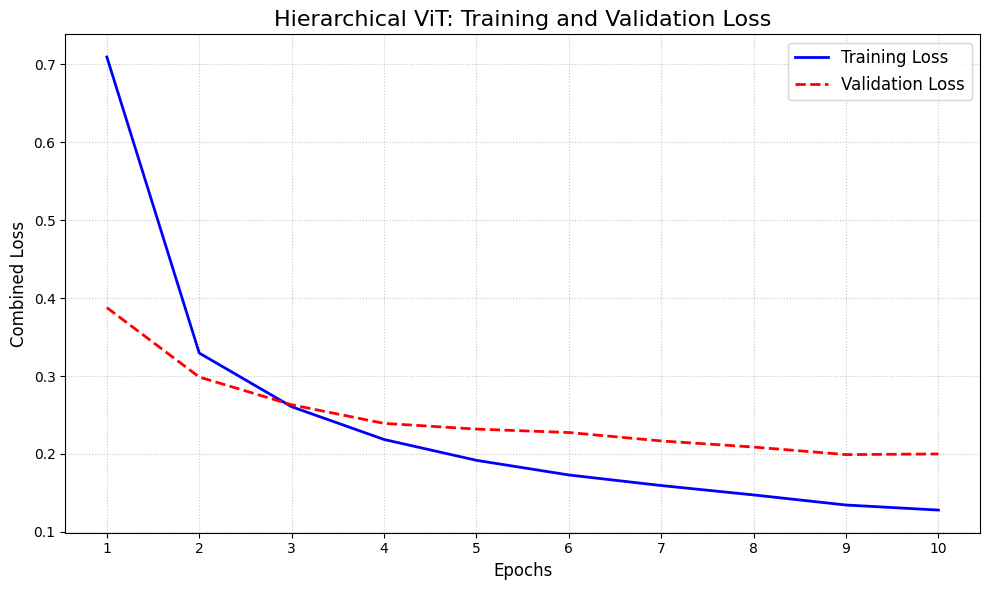

In [26]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """Plots the training and validation loss curves.

    Args:
        history (dict): A dictionary containing 'train_loss' and 'val_loss' lists,
                        typically returned by the training loop.

    Returns:
        None
    """
    # Extract the loss values from the history dictionary
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    
    # Create a sequence of epoch numbers for the x-axis (starting at 1)
    epochs = range(1, len(train_loss) + 1)
    
    # Initialize the plot figure
    plt.figure(figsize=(10, 6))
    
    # Plot both the training and validation losses
    plt.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss', linewidth=2)
    
    # Add labels, title, and a grid for readability
    plt.title('Hierarchical ViT: Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Combined Loss', fontsize=12)
    
    # Force the x-axis to display integer ticks for epochs
    plt.xticks(epochs)
    
    plt.legend(fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.7)
    
    # Display the final plot
    plt.tight_layout()
    plt.show()

# ==========================================
# Example usage after running your training loop:
# ==========================================
plot_training_history(history)

In [35]:
import torch

def save_trained_model(model, filepath="zooplankton_vit_weights.pth"):
    """Saves the learned weights of the model to a file."""
    
    # Extract the dictionary of weights
    weights_dictionary = model.state_dict()
    
    # Save the dictionary to the specified file path
    torch.save(weights_dictionary, filepath)
    
    print(f"Success: Model weights securely saved to '{filepath}'")

# ==========================================
# Example usage after training:
# ==========================================
save_trained_model(model, filepath="models/best_zooplankton_model.pth")

Success: Model weights securely saved to 'models/best_zooplankton_model.pth'


In [37]:
import torch

def load_trained_model(filepath, device):
    """Creates a blank model and loads the saved weights into it."""
    
    # 1. Instantiate the EXACT same class architecture you trained with
    # We set pretrained=False because we are about to load our own custom weights
    model = HierarchicalZooplanktonViT(pretrained=False)
    
    # 2. Load the dictionary of weights from your file
    # map_location ensures it loads correctly whether you are on Mac or a GPU
    saved_weights = torch.load(filepath, map_location=device, weights_only=True)
    
    # 3. Pour the weights into the blank model
    model.load_state_dict(saved_weights)
    
    # 4. Move the model to your active device (CPU, MPS, or CUDA)
    model = model.to(device)
    
    # 5. Lock the model into evaluation mode for inference
    model.eval()
    
    print(f"Success: Model weights loaded from '{filepath}'")
    
    return model


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = load_trained_model("models/best_zooplankton_model.pth", device)

Success: Model weights loaded from 'models/best_zooplankton_model.pth'


In [38]:
# Level 0 depends on the very top of the tree
VALID_L0_MAPPING = {
    "ROOT": [0, 1]
}

# Level 1 depends on Level 0 predictions
VALID_L1_MAPPING = {
    1: [0, 1, 2],
    0: [3, 4, 5]
}

# Level 2 depends on Level 1 predictions
VALID_L2_MAPPING = {
    0: [0, 1],
    2: [2, 3, 4, 5]
}

In [39]:
import torch

def predict_strict_hierarchy(model, images, map_l0, map_l1, map_l2):
    """Predicts the hierarchy using identical logic blocks for every single level."""
    model.eval()
    
    with torch.no_grad():
        logits = model(images)
        batch_size = images.shape[0]
        
        pred_l0_list = []
        pred_l1_list = []
        pred_l2_list = []
        
        for i in range(batch_size):
            
            # ==========================================
            # STEP 0: Level 0 Prediction
            # ==========================================
            l0_logits = logits['L0'][i].clone()
            parent_l0 = "ROOT"  # Level 0's fake parent
            
            if parent_l0 in map_l0:
                valid_l0_classes = map_l0[parent_l0]
                for class_idx in range(len(l0_logits)):
                    if class_idx not in valid_l0_classes:
                        l0_logits[class_idx] = float('-inf')
                l0_pred = torch.argmax(l0_logits).item()
            else:
                l0_pred = -1
                
            pred_l0_list.append(l0_pred)
            
            # ==========================================
            # STEP 1: Level 1 Prediction
            # ==========================================
            l1_logits = logits['L1'][i].clone()
            parent_l1 = l0_pred  # Level 1's parent is the Level 0 prediction
            
            if parent_l1 in map_l1:
                valid_l1_classes = map_l1[parent_l1]
                for class_idx in range(len(l1_logits)):
                    if class_idx not in valid_l1_classes:
                        l1_logits[class_idx] = float('-inf')
                l1_pred = torch.argmax(l1_logits).item()
            else:
                l1_pred = -1
                
            pred_l1_list.append(l1_pred)
            
            # ==========================================
            # STEP 2: Level 2 Prediction
            # ==========================================
            l2_logits = logits['L2'][i].clone()
            parent_l2 = l1_pred  # Level 2's parent is the Level 1 prediction
            
            if parent_l2 in map_l2:
                valid_l2_classes = map_l2[parent_l2]
                for class_idx in range(len(l2_logits)):
                    if class_idx not in valid_l2_classes:
                        l2_logits[class_idx] = float('-inf')
                l2_pred = torch.argmax(l2_logits).item()
            else:
                l2_pred = -1
                
            pred_l2_list.append(l2_pred)

        # Convert to tensors
        device = images.device
        pred_l0_tensor = torch.tensor(pred_l0_list, device=device)
        pred_l1_tensor = torch.tensor(pred_l1_list, device=device)
        pred_l2_tensor = torch.tensor(pred_l2_list, device=device)
        
        return pred_l0_tensor, pred_l1_tensor, pred_l2_tensor

In [40]:
from tqdm import tqdm

def evaluate_hierarchical_model(model, test_loader, device, map_l0, map_l1, map_l2):
    """Evaluates the model on the test set using explicit, level-by-level scoring."""
    model.eval()
    
    # Initialize our counters
    total_samples = 0
    correct_l0 = 0
    correct_l1 = 0
    correct_l2 = 0
    strict_correct = 0
    
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating Test Set"):
            images = images.to(device)
            
            # Move the true target labels to the device
            t_l0 = targets['L0'].to(device)
            t_l1 = targets['L1'].to(device)
            t_l2 = targets['L2'].to(device)
            
            # Run our standardized inference function
            p_l0, p_l1, p_l2 = predict_strict_hierarchy(model, images, map_l0, map_l1, map_l2)
            
            # Add the number of images in this batch to our total
            batch_size = images.size(0)
            total_samples += batch_size
            
            # ==========================================
            # SCORING STEP 0: Level 0
            # ==========================================
            correct_l0 += (p_l0 == t_l0).sum().item()
            
            # ==========================================
            # SCORING STEP 1: Level 1
            # ==========================================
            correct_l1 += (p_l1 == t_l1).sum().item()
            
            # ==========================================
            # SCORING STEP 2: Level 2
            # ==========================================
            correct_l2 += (p_l2 == t_l2).sum().item()
            
            # ==========================================
            # SCORING STEP 3: Strict Path Accuracy
            # ==========================================
            # The model only gets a point if all three levels are perfectly correct
            path_correct = (p_l0 == t_l0) & (p_l1 == t_l1) & (p_l2 == t_l2)
            strict_correct += path_correct.sum().item()

    # Calculate final percentages
    acc_l0 = (correct_l0 / total_samples) * 100
    acc_l1 = (correct_l1 / total_samples) * 100
    acc_l2 = (correct_l2 / total_samples) * 100
    acc_strict = (strict_correct / total_samples) * 100
    
    # Print the results in a clean format
    print("\n" + "="*30)
    print("FINAL TEST SET EVALUATION")
    print("="*30)
    print(f"Level 0 Accuracy: {acc_l0:.2f}%")
    print(f"Level 1 Accuracy: {acc_l1:.2f}%")
    print(f"Level 2 Accuracy: {acc_l2:.2f}%")
    print("-" * 30)
    print(f"Strict Path Accuracy: {acc_strict:.2f}%")
    print("="*30)
    
    return acc_strict

# ==========================================
# Example usage to run the evaluation
# ==========================================
test_accuracy = evaluate_hierarchical_model(
    model=model, 
    test_loader=test_loader, 
    device=device, 
    map_l0=VALID_L0_MAPPING, 
    map_l1=VALID_L1_MAPPING, 
    map_l2=VALID_L2_MAPPING
)

Evaluating Test Set: 100%|██████████████████████| 55/55 [00:32<00:00,  1.69it/s]


FINAL TEST SET EVALUATION
Level 0 Accuracy: 99.19%
Level 1 Accuracy: 96.66%
Level 2 Accuracy: 85.47%
------------------------------
Strict Path Accuracy: 84.60%
